<a href="https://colab.research.google.com/github/win4r/win4r.github.io/blob/main/Florence-2-large-test.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Florence-2-large sample usage

In [4]:
!pip install flash_attn timm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.6/2.6 MB 73.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.4/42.4 kB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 85.2 MB/s eta 0:00:00
  Created wheel for flash_attn: filename=flash_attn-2.6.3-cp310-cp310-linux_x86_64.whl size=187309225 sha256=237ef9c6157db394e1ddde4ba609a21ebb98382377a27041edc09318801a6f24
  Stored in directory: /root/.cache/pip/wheels/7e/e3/c3/89c7a2f3c4adc07cd1c675f8bb7b9ad4d18f64a72bccdfe826
Successfully built flash_attn


In [1]:
from transformers import AutoProcessor, AutoModelForCausalLM
from PIL import Image
import requests
import copy
import torch
%matplotlib inline

In [5]:
model_id = 'microsoft/Florence-2-large'
model = AutoModelForCausalLM.from_pretrained(model_id, trust_remote_code=True, torch_dtype='auto').eval().cuda()
processor = AutoProcessor.from_pretrained(model_id, trust_remote_code=True)

pytorch_model.bin:   0%|          | 0.00/1.54G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/51.0 [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/806 [00:00<?, ?B/s]

processing_florence2.py:   0%|          | 0.00/46.4k [00:00<?, ?B/s]

A new version of the following files was downloaded from https://huggingface.co/microsoft/Florence-2-large:
- processing_florence2.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.


tokenizer_config.json:   0%|          | 0.00/34.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.10M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


## define the prediction function

In [6]:
def run_example(task_prompt, text_input=None):
    if text_input is None:
        prompt = task_prompt
    else:
        prompt = task_prompt + text_input
    inputs = processor(text=prompt, images=image, return_tensors="pt").to('cuda', torch.float16)
    generated_ids = model.generate(
      input_ids=inputs["input_ids"].cuda(),
      pixel_values=inputs["pixel_values"].cuda(),
      max_new_tokens=1024,
      early_stopping=False,
      do_sample=False,
      num_beams=3,
    )
    generated_text = processor.batch_decode(generated_ids, skip_special_tokens=False)[0]
    parsed_answer = processor.post_process_generation(
        generated_text,
        task=task_prompt,
        image_size=(image.width, image.height)
    )

    return parsed_answer

## init image

In [30]:
url = "https://img-blog.csdnimg.cn/ebe1957a658045f489a91896fc331522.png"
image = Image.open(requests.get(url, stream=True).raw)

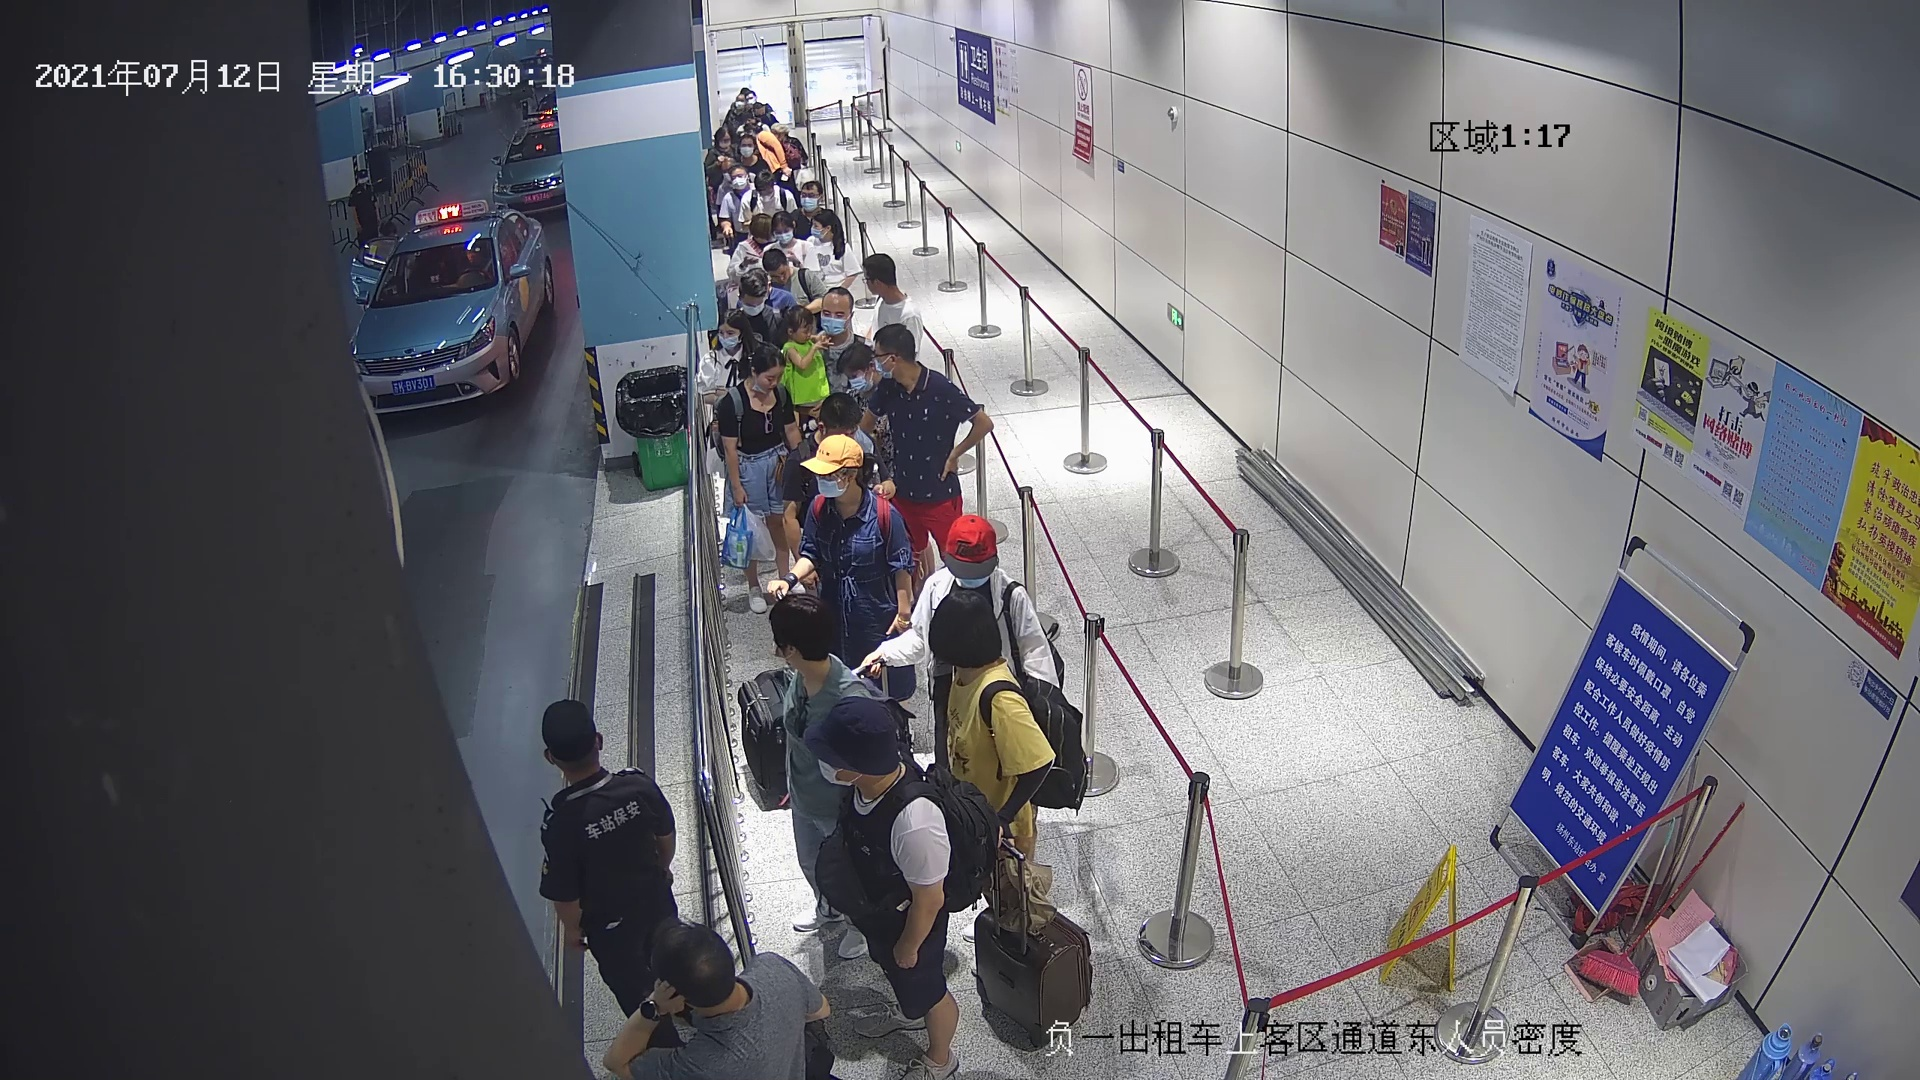

In [31]:
image

## Run pre-defined tasks without additional inputs

### Caption

In [32]:
task_prompt = '<CAPTION>'
run_example(task_prompt)

{'<CAPTION>': 'A group of people standing in line at an airport.'}

In [33]:
task_prompt = '<DETAILED_CAPTION>'
run_example(task_prompt)

{'<DETAILED_CAPTION>': 'The image shows a group of people standing in line at an airport, with some of them wearing caps and bags. There are poles with ropes and boards with text on the walls, as well as bottles and other items scattered around. In the background, there are vehicles on the road and lights illuminating the scene. At the top and bottom of the image, there is text indicating that this is a CCTV footage of the Hong Kong airport.'}

In [34]:
task_prompt = '<MORE_DETAILED_CAPTION>'
run_example(task_prompt)

{'<MORE_DETAILED_CAPTION>': 'The image shows a group of people standing in an airport terminal. The terminal has a long line of people on the right side of the image, with a red rope barrier separating them from the rest of the space. On the left side, there is a blue car parked on the floor. The people in the image appear to be waiting in line, with some of them carrying luggage. There are posters and information boards on the walls, indicating that the terminal is closed due to the COVID-19 pandemic. The image is taken from a high angle, looking down on the people and the car.'}

### Object detection

OD results format:
{'\<OD>':
    {
    'bboxes': [[x1, y1, x2, y2], ...],
    'labels': ['label1', 'label2', ...]
    }
}

In [35]:
task_prompt = '<OD>'
results = run_example(task_prompt)
print(results)

{'<OD>': {'bboxes': [[344.6399841308594, 200.3400115966797, 561.5999755859375, 413.1000061035156], [888.0, 1055.7000732421875, 964.7999877929688, 1078.3800048828125], [490.55999755859375, 123.66000366210938, 569.2799682617188, 213.3000030517578], [532.7999877929688, 86.94000244140625, 1091.52001953125, 1078.3800048828125], [797.760009765625, 694.9800415039062, 989.7599487304688, 1078.3800048828125], [530.8800048828125, 698.2200317382812, 690.239990234375, 1018.9800415039062], [757.4400024414062, 591.300048828125, 903.3599853515625, 934.7400512695312], [918.719970703125, 585.9000244140625, 1072.3199462890625, 864.5400390625], [598.0800170898438, 919.6200561523438, 843.8399658203125, 1078.3800048828125], [855.3599853515625, 322.3800048828125, 1001.2799682617188, 571.8600463867188], [765.1199951171875, 433.6200256347656, 928.3200073242188, 664.7400512695312]], 'labels': ['car', 'footwear', 'land vehicle', 'person', 'person', 'person', 'person', 'person', 'person', 'person', 'person']}}


In [36]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
def plot_bbox(image, data):
   # Create a figure and axes
    fig, ax = plt.subplots()

    # Display the image
    ax.imshow(image)

    # Plot each bounding box
    for bbox, label in zip(data['bboxes'], data['labels']):
        # Unpack the bounding box coordinates
        x1, y1, x2, y2 = bbox
        # Create a Rectangle patch
        rect = patches.Rectangle((x1, y1), x2-x1, y2-y1, linewidth=1, edgecolor='r', facecolor='none')
        # Add the rectangle to the Axes
        ax.add_patch(rect)
        # Annotate the label
        plt.text(x1, y1, label, color='white', fontsize=8, bbox=dict(facecolor='red', alpha=0.5))

    # Remove the axis ticks and labels
    ax.axis('off')

    # Show the plot
    plt.show()

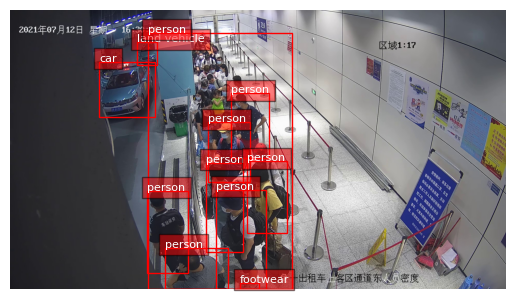

In [37]:
plot_bbox(image, results['<OD>'])

### Dense region caption

Dense region caption results format:
{'\<DENSE_REGION_CAPTION>': {'bboxes': [[x1, y1, x2, y2], ...], 'labels': ['label1', 'label2', ...]}}

In [38]:
task_prompt = '<DENSE_REGION_CAPTION>'
results = run_example(task_prompt)
print(results)

{'<DENSE_REGION_CAPTION>': {'bboxes': [[536.6400146484375, 86.94000244140625, 1087.679931640625, 1078.3800048828125], [532.7999877929688, 698.2200317382812, 697.9199829101562, 1078.3800048828125], [799.6799926757812, 694.9800415039062, 976.3200073242188, 1078.3800048828125], [755.5199584960938, 591.300048828125, 907.199951171875, 958.5000610351562], [920.6399536132812, 585.9000244140625, 1074.239990234375, 908.8200073242188], [346.55999755859375, 200.3400115966797, 561.5999755859375, 413.1000061035156], [598.0800170898438, 919.6200561523438, 843.8399658203125, 1078.3800048828125], [765.1199951171875, 433.6200256347656, 928.3200073242188, 666.9000244140625], [855.3599853515625, 322.3800048828125, 999.3599853515625, 569.7000122070312], [707.5199584960938, 349.3800048828125, 813.1199951171875, 612.9000244140625], [490.55999755859375, 123.66000366210938, 571.2000122070312, 213.3000030517578], [849.5999755859375, 1012.5000610351562, 930.239990234375, 1039.5], [886.0799560546875, 1055.700073

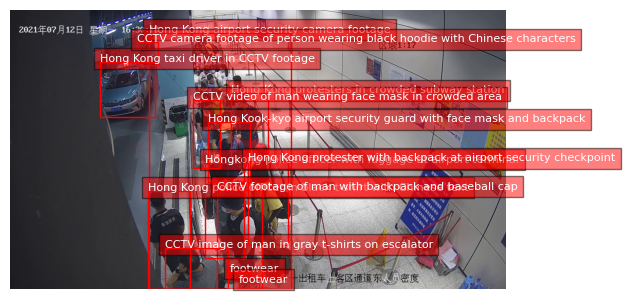

In [39]:
plot_bbox(image, results['<DENSE_REGION_CAPTION>'])

### Region proposal

Region proposal results format:
{'<REGION_PROPOSAL>' : {'bboxes': [[x1, y1, x2, y2], ...], 'labels': ['', '', ...]}}

In [40]:
task_prompt = '<REGION_PROPOSAL>'
results = run_example(task_prompt)
print(results)

{'<REGION_PROPOSAL>': {'bboxes': [[0.9599999785423279, 0.5400000214576721, 1917.1199951171875, 1078.3800048828125], [534.719970703125, 86.94000244140625, 1091.52001953125, 1078.3800048828125], [696.0, 86.94000244140625, 1083.8399658203125, 1078.3800048828125], [699.8399658203125, 86.94000244140625, 1003.199951171875, 658.260009765625], [701.760009765625, 86.94000244140625, 866.8800048828125, 611.8200073242188], [797.760009765625, 694.9800415039062, 995.5199584960938, 1078.3800048828125], [532.7999877929688, 698.2200317382812, 692.1599731445312, 1078.3800048828125], [755.5199584960938, 591.300048828125, 911.0399780273438, 957.4200439453125], [918.719970703125, 585.9000244140625, 1074.239990234375, 908.8200073242188], [532.7999877929688, 698.2200317382812, 688.3200073242188, 1017.9000244140625], [344.6399841308594, 200.3400115966797, 561.5999755859375, 413.1000061035156], [861.1199951171875, 513.5400390625, 1068.47998046875, 700.3800048828125], [598.0800170898438, 919.6200561523438, 841.

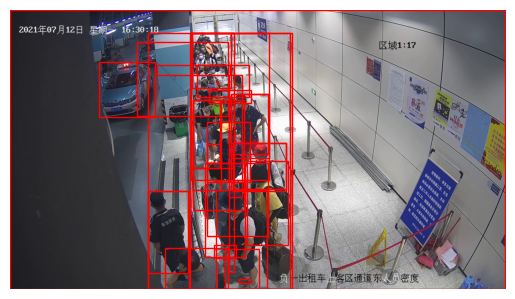

In [41]:
plot_bbox(image, results['<REGION_PROPOSAL>'])

## Run pre-defined tasks that requires additional inputs

### Phrase Grounding
Phrase grounding results format:
{'\<CAPTION_TO_PHRASE_GROUNDING>': {'bboxes': [[x1, y1, x2, y2], ...], 'labels': ['', '', ...]}}

In [53]:
task_prompt = '<CAPTION_TO_PHRASE_GROUNDING>'
results = run_example(task_prompt, text_input="yellow hat man.")
print(results)

{'<CAPTION_TO_PHRASE_GROUNDING>': {'bboxes': [[799.6799926757812, 431.46002197265625, 866.8800048828125, 477.9000244140625]], 'labels': ['yellow hat man']}}


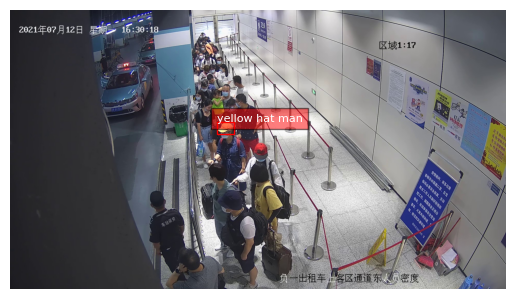

In [54]:
plot_bbox(image, results['<CAPTION_TO_PHRASE_GROUNDING>'])

In [57]:
task_prompt = '<CAPTION_TO_PHRASE_GROUNDING>'
results = run_example(task_prompt, text_input="red hat person.")
print(results)

{'<CAPTION_TO_PHRASE_GROUNDING>': {'bboxes': [[941.7599487304688, 511.3800354003906, 999.3599853515625, 566.4600219726562], [799.6799926757812, 431.46002197265625, 866.8800048828125, 477.9000244140625]], 'labels': ['red hat person', 'red hat person']}}


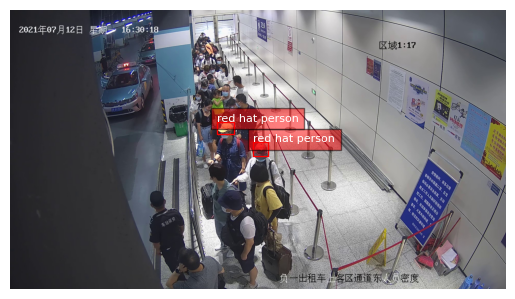

In [58]:
plot_bbox(image, results['<CAPTION_TO_PHRASE_GROUNDING>'])

### Referring expression segmentation

Referring expression segmentation results format:
{'\<REFERRING_EXPRESSION_SEGMENTATION>': {'Polygons': [[[polygon]], ...], 'labels': ['', '', ...]}}, one object is represented by a list of polygons. each polygon is [x1, y1, x2, y2, ..., xn, yn]

In [44]:
task_prompt = '<REFERRING_EXPRESSION_SEGMENTATION>'
results = run_example(task_prompt, text_input="a green car")
print(results)

{'<REFERRING_EXPRESSION_SEGMENTATION>': {'polygons': [[[419.5199890136719, 211.1400146484375, 421.44000244140625, 210.0600128173828, 423.3599853515625, 208.98001098632812, 425.2799987792969, 208.98001098632812, 427.1999816894531, 207.90000915527344, 429.1199951171875, 207.90000915527344, 431.03997802734375, 206.82000732421875, 432.9599914550781, 205.74000549316406, 434.8800048828125, 205.74000549316406, 436.79998779296875, 204.66000366210938, 438.7200012207031, 204.66000366210938, 440.6399841308594, 203.5800018310547, 442.55999755859375, 202.50001525878906, 444.47998046875, 202.50001525878906, 446.3999938964844, 201.42001342773438, 448.3199768066406, 201.42001342773438, 450.239990234375, 200.3400115966797, 452.1600036621094, 200.3400115966797, 454.0799865722656, 199.260009765625, 456.0, 199.260009765625, 457.91998291015625, 198.1800079345703, 459.8399963378906, 198.1800079345703, 461.7599792480469, 197.10000610351562, 463.67999267578125, 197.10000610351562, 465.5999755859375, 196.02000

In [26]:
from PIL import Image, ImageDraw, ImageFont
import random
import numpy as np
colormap = ['blue','orange','green','purple','brown','pink','gray','olive','cyan','red',
            'lime','indigo','violet','aqua','magenta','coral','gold','tan','skyblue']
def draw_polygons(image, prediction, fill_mask=False):
    """
    Draws segmentation masks with polygons on an image.

    Parameters:
    - image_path: Path to the image file.
    - prediction: Dictionary containing 'polygons' and 'labels' keys.
                  'polygons' is a list of lists, each containing vertices of a polygon.
                  'labels' is a list of labels corresponding to each polygon.
    - fill_mask: Boolean indicating whether to fill the polygons with color.
    """
    # Load the image

    draw = ImageDraw.Draw(image)


    # Set up scale factor if needed (use 1 if not scaling)
    scale = 1

    # Iterate over polygons and labels
    for polygons, label in zip(prediction['polygons'], prediction['labels']):
        color = random.choice(colormap)
        fill_color = random.choice(colormap) if fill_mask else None

        for _polygon in polygons:
            _polygon = np.array(_polygon).reshape(-1, 2)
            if len(_polygon) < 3:
                print('Invalid polygon:', _polygon)
                continue

            _polygon = (_polygon * scale).reshape(-1).tolist()

            # Draw the polygon
            if fill_mask:
                draw.polygon(_polygon, outline=color, fill=fill_color)
            else:
                draw.polygon(_polygon, outline=color)

            # Draw the label text
            draw.text((_polygon[0] + 8, _polygon[1] + 2), label, fill=color)

    # Save or display the image
    #image.show()  # Display the image
    display(image)

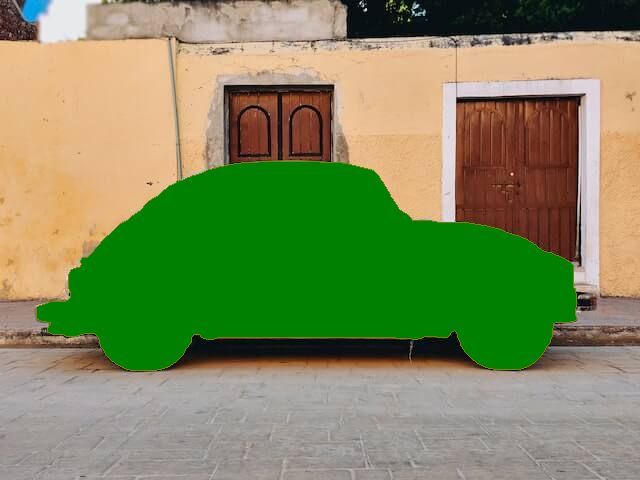

In [27]:
output_image = copy.deepcopy(image)
draw_polygons(output_image, results['<REFERRING_EXPRESSION_SEGMENTATION>'], fill_mask=True)

### region to segmentation


with additional region as inputs, format is '\<loc_x1>\<loc_y1>\<loc_x2>\<loc_y2>', [x1, y1, x2, y2] is the quantized corrdinates in [0, 999].

In [28]:
task_prompt = '<REGION_TO_SEGMENTATION>'
results = run_example(task_prompt, text_input="<loc_702><loc_575><loc_866><loc_772>")
print(results)

{'<REGION_TO_SEGMENTATION>': {'polygons': [[[470.0799865722656, 288.239990234375, 473.91998291015625, 285.3599853515625, 477.1199951171875, 283.44000244140625, 479.03997802734375, 282.47998046875, 480.9599914550781, 282.47998046875, 484.1600036621094, 280.55999755859375, 486.7200012207031, 279.6000061035156, 489.91998291015625, 278.6399841308594, 495.03997802734375, 277.67999267578125, 512.3200073242188, 277.67999267578125, 514.8800048828125, 278.6399841308594, 518.0800170898438, 279.6000061035156, 521.2799682617188, 281.5199890136719, 523.2000122070312, 281.5199890136719, 525.1199951171875, 283.44000244140625, 528.3200073242188, 284.3999938964844, 530.8800048828125, 286.32000732421875, 534.0800170898438, 288.239990234375, 543.0399780273438, 297.3599853515625, 544.9599609375, 300.239990234375, 546.8800048828125, 303.1199951171875, 550.0800170898438, 309.3599853515625, 551.3599853515625, 312.239990234375, 552.0, 315.1199951171875, 553.2799682617188, 319.44000244140625, 553.2799682617188

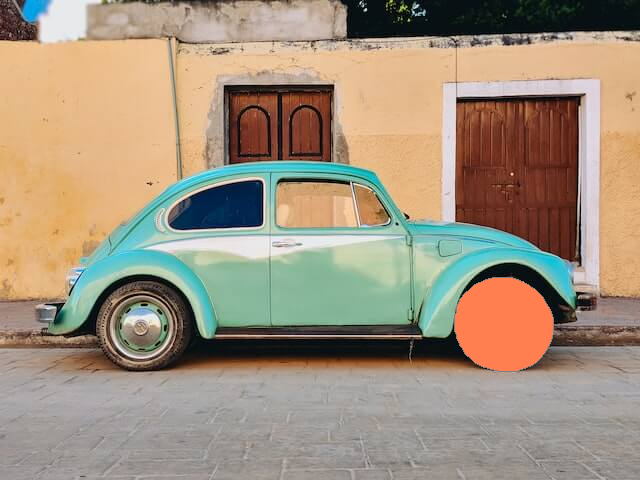

In [29]:
output_image = copy.deepcopy(image)
draw_polygons(output_image, results['<REGION_TO_SEGMENTATION>'], fill_mask=True)

### Open vocabulary detection

open vocabulary detection can detect both objects and ocr texts.

results format:

{ '\<OPEN_VOCABULARY_DETECTION>': {'bboxes': [[x1, y1, x2, y2], [x1, y1, x2, y2], ...]], 'bboxes_labels': ['label_1', 'label_2', ..],
'polygons': [[[x1, y1, x2, y2, ..., xn, yn], [x1, y1, ..., xn, yn]], ...], 'polygons_labels': ['label_1', 'label_2', ...]
}}

In [ ]:
task_prompt = '<OPEN_VOCABULARY_DETECTION>'
results = run_example(task_prompt, text_input="a green car")
print(results)

{'<OPEN_VOCABULARY_DETECTION>': {'bboxes': [[34.23999786376953, 158.63999938964844, 582.0800170898438, 374.1600036621094]], 'bboxes_labels': ['a green car'], 'polygons': [], 'polygons_labels': []}}


In [ ]:
def convert_to_od_format(data):
    """
    Converts a dictionary with 'bboxes' and 'bboxes_labels' into a dictionary with separate 'bboxes' and 'labels' keys.

    Parameters:
    - data: The input dictionary with 'bboxes', 'bboxes_labels', 'polygons', and 'polygons_labels' keys.

    Returns:
    - A dictionary with 'bboxes' and 'labels' keys formatted for object detection results.
    """
    # Extract bounding boxes and labels
    bboxes = data.get('bboxes', [])
    labels = data.get('bboxes_labels', [])

    # Construct the output format
    od_results = {
        'bboxes': bboxes,
        'labels': labels
    }

    return od_results

In [ ]:
bbox_results  = convert_to_od_format(results['<OPEN_VOCABULARY_DETECTION>'])

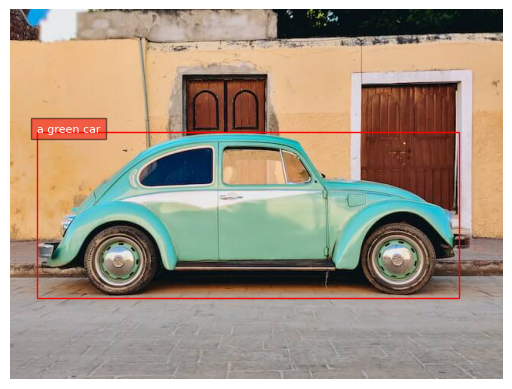

In [ ]:
plot_bbox(image, bbox_results)

### region to texts

In [ ]:
task_prompt = '<REGION_TO_CATEGORY>'
results = run_example(task_prompt, text_input="<loc_52><loc_332><loc_932><loc_774>")
print(results)

{'<REGION_TO_CATEGORY>': 'car<loc_52><loc_332><loc_932><loc_774>'}


In [ ]:
task_prompt = '<REGION_TO_DESCRIPTION>'
results = run_example(task_prompt, text_input="<loc_52><loc_332><loc_932><loc_774>")
print(results)

{'<REGION_TO_DESCRIPTION>': 'turquoise Volkswagen Beetle<loc_52><loc_332><loc_932><loc_774>'}


## ocr related tasks

In [ ]:
url = "http://ecx.images-amazon.com/images/I/51UUzBDAMsL.jpg?download=true"
image = Image.open(requests.get(url, stream=True).raw).convert('RGB')

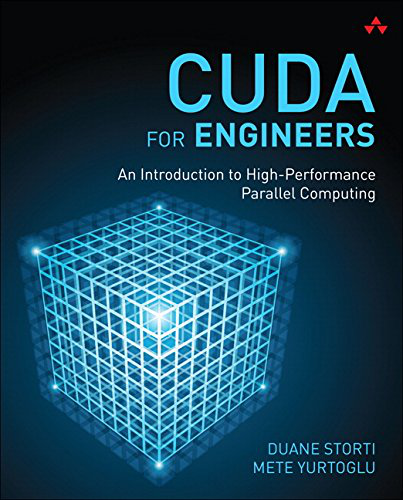

In [ ]:
image

In [ ]:
task_prompt = '<OCR>'
run_example(task_prompt)

{'<OCR>': 'CUDAFOR ENGINEERSAn Introduction to High-PerformanceParallel ComputingDUANE STORTIMETE YURTOGLU'}

In [ ]:
task_prompt = '<OCR_WITH_REGION>'
results = run_example(task_prompt)
print(results)
# ocr results format
# {'OCR_WITH_REGION': {'quad_boxes': [[x1, y1, x2, y2, x3, y3, x4, y4], ...], 'labels': ['text1', ...]}}

{'<OCR_WITH_REGION>': {'quad_boxes': [[167.0435028076172, 50.25, 376.20050048828125, 50.25, 376.20050048828125, 114.75, 167.0435028076172, 114.75], [144.8784942626953, 120.75, 375.3945007324219, 120.75, 375.3945007324219, 149.25, 144.8784942626953, 149.25], [115.86249542236328, 165.25, 376.20050048828125, 166.25, 376.20050048828125, 184.25, 115.86249542236328, 183.25], [239.9864959716797, 184.25, 376.20050048828125, 186.25, 376.20050048828125, 204.25, 239.9864959716797, 202.25], [266.1814880371094, 441.25, 376.20050048828125, 441.25, 376.20050048828125, 456.25, 266.1814880371094, 456.25], [252.0764923095703, 460.25, 376.20050048828125, 460.25, 376.20050048828125, 475.25, 252.0764923095703, 475.25]], 'labels': ['</s>CUDA', 'FOR ENGINEERS', 'An Introduction to High-Performance', 'Parallel Computing', 'DUANE STORTI', 'METE YURTOGLU']}}


In [ ]:
def draw_ocr_bboxes(image, prediction, scale=1):
    draw = ImageDraw.Draw(image)
    bboxes, labels = prediction['quad_boxes'], prediction['labels']
    for box, label in zip(bboxes, labels):
        color = random.choice(colormap)
        new_box = (np.array(box) * scale).tolist()
        draw.polygon(new_box, width=3, outline=color)
        draw.text((new_box[0]+8, new_box[1]+2),
                    "{}".format(label),
                    align="right",

                    fill=color)

    display(image)

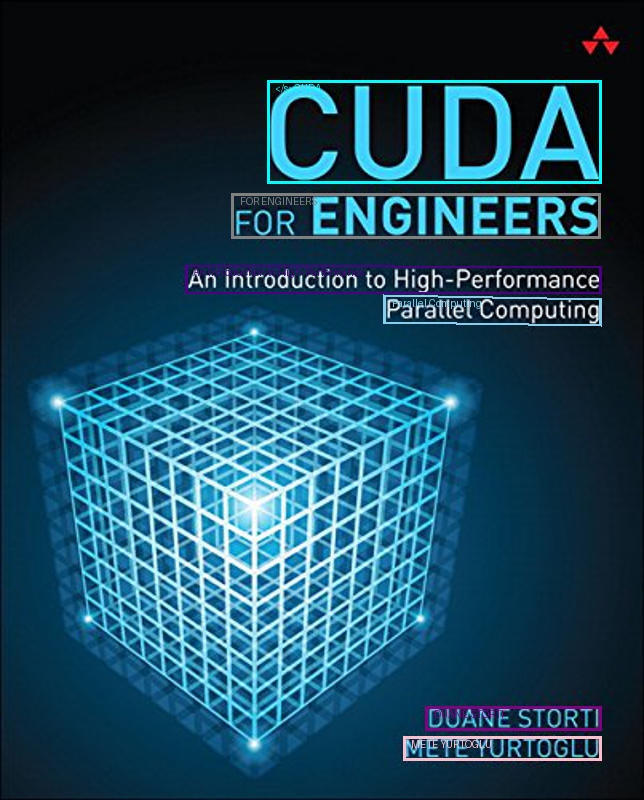

In [ ]:
output_image = copy.deepcopy(image)
w, h = output_image.size
scale = 800 / max(w, h)
new_output_image = output_image.resize((int(w * scale), int(h * scale)))
draw_ocr_bboxes(new_output_image, results['<OCR_WITH_REGION>'], scale=scale)

## Cascaded tasks

### Caption + Phrase Grounding

results format:

{
 '\<CAPTION': pure_text,
{'\<CAPTION_TO_PHRASE_GROUNDING>': {'bboxes': [[x1, y1, x2, y2], ...], 'labels': ['', '', ...]}}
}

In [ ]:
url = "https://huggingface.co/datasets/huggingface/documentation-images/resolve/main/transformers/tasks/car.jpg?download=true"
image = Image.open(requests.get(url, stream=True).raw)

In [ ]:
task_prompt = '<CAPTION>'
results = run_example(task_prompt)
text_input = results[task_prompt]
task_prompt = '<CAPTION_TO_PHRASE_GROUNDING>'
results = run_example(task_prompt, text_input)
results['<CAPTION>'] = text_input

In [ ]:
results

{'<CAPTION_TO_PHRASE_GROUNDING>': {'bboxes': [[34.23999786376953,
    159.1199951171875,
    582.0800170898438,
    374.6399841308594],
   [1.5999999046325684,
    4.079999923706055,
    639.0399780273438,
    305.03997802734375]],
  'labels': ['A green car', 'a yellow building']},
 '<CAPTION>': 'A green car parked in front of a yellow building.'}

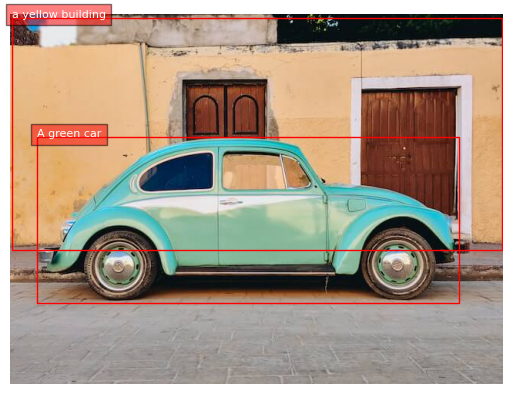

In [ ]:
plot_bbox(image, results['<CAPTION_TO_PHRASE_GROUNDING>'])

### Detailed Caption + Phrase Grounding

results format:

{
 '\<DETAILED_CAPTION': pure_text,
{'\<CAPTION_TO_PHRASE_GROUNDING>': {'bboxes': [[x1, y1, x2, y2], ...], 'labels': ['', '', ...]}}
}

In [ ]:
task_prompt = '<DETAILED_CAPTION>'
results = run_example(task_prompt)
text_input = results[task_prompt]
task_prompt = '<CAPTION_TO_PHRASE_GROUNDING>'
results = run_example(task_prompt, text_input)
results['<DETAILED_CAPTION>'] = text_input

In [ ]:
results

{'<CAPTION_TO_PHRASE_GROUNDING>': {'bboxes': [[33.599998474121094,
    158.63999938964844,
    582.719970703125,
    375.1199951171875],
   [1.5999999046325684, 5.039999961853027, 639.0399780273438, 306.0],
   [452.79998779296875,
    94.31999969482422,
    582.0800170898438,
    265.67999267578125],
   [222.39999389648438,
    84.23999786376953,
    335.03997802734375,
    167.27999877929688],
   [2.240000009536743,
    1.1999999284744263,
    639.0399780273438,
    43.91999816894531],
   [343.3599853515625,
    1.1999999284744263,
    639.0399780273438,
    40.55999755859375],
   [2.240000009536743,
    1.1999999284744263,
    638.3999633789062,
    43.91999816894531],
   [18.239999771118164,
    1.1999999284744263,
    104.63999938964844,
    45.36000061035156]],
  'labels': ['a blue Volkswagen Beetle',
   'a yellow building',
   'brown doors',
   'brown doors',
   'trees',
   'trees',
   'a clear blue sky',
   'a clear blue sky']},
 '<DETAILED_CAPTION>': 'The image shows a blue Vol

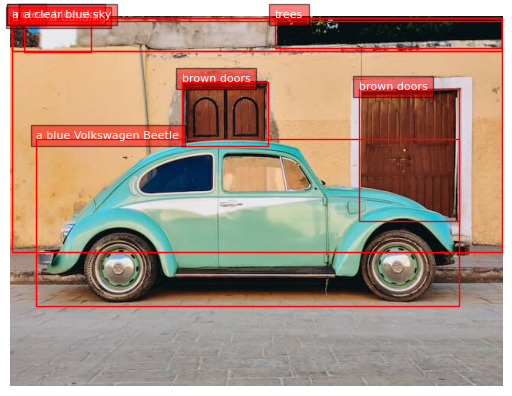

In [ ]:
plot_bbox(image, results['<CAPTION_TO_PHRASE_GROUNDING>'])

### More Detailed Caption + Phrase Grounding

results format:

{
 '\<MORE_DETAILED_CAPTION': pure_text,
{'\<CAPTION_TO_PHRASE_GROUNDING>': {'bboxes': [[x1, y1, x2, y2], ...], 'labels': ['', '', ...]}}
}

In [ ]:
task_prompt = '<MORE_DETAILED_CAPTION>'
results = run_example(task_prompt)
text_input = results[task_prompt]
task_prompt = '<CAPTION_TO_PHRASE_GROUNDING>'
results = run_example(task_prompt, text_input)
results['<MORE_DETAILED_CAPTION>'] = text_input

In [ ]:
results

{'<CAPTION_TO_PHRASE_GROUNDING>': {'bboxes': [[35.52000045776367,
    157.67999267578125,
    581.4400024414062,
    372.7200012207031],
   [1.5999999046325684,
    340.0799865722656,
    639.0399780273438,
    479.2799987792969],
   [454.0799865722656,
    93.83999633789062,
    580.7999877929688,
    263.2799987792969],
   [223.67999267578125,
    84.23999786376953,
    333.7599792480469,
    163.9199981689453],
   [36.79999923706055,
    157.67999267578125,
    580.1599731445312,
    372.239990234375],
   [454.0799865722656,
    93.83999633789062,
    581.4400024414062,
    263.2799987792969],
   [223.67999267578125,
    84.72000122070312,
    333.7599792480469,
    163.9199981689453],
   [164.16000366210938,
    177.36000061035156,
    265.2799987792969,
    232.0800018310547],
   [2.879999876022339,
    4.559999942779541,
    639.0399780273438,
    301.1999816894531],
   [19.520000457763672, 1.1999999284744263, 639.0399780273438, 42.0],
   [20.15999984741211,
    0.719999969005584

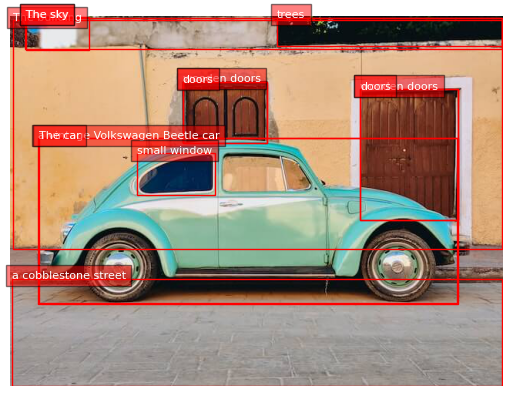

In [ ]:
plot_bbox(image, results['<CAPTION_TO_PHRASE_GROUNDING>'])